In [1]:
!pip install gymnasium numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.1 MB/s eta 0:00:00


In [15]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
from IPython.display import clear_output

In [9]:
# Define the Q-Network using a simple feedforward neural network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)  # Increased neurons for better GPU utilization
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.batch_size = 256
        self.model = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.model(states)
        next_q_values = self.model(next_states)
        q_target = q_values.clone()

        for i in range(self.batch_size):
            q_target[i, actions[i]] = rewards[i] + (self.gamma * torch.max(next_q_values[i]) * (1 - dones[i]))

        self.optimizer.zero_grad()
        loss = self.criterion(q_values, q_target)
        loss.backward()
        self.optimizer.step()

        # Decay epsilon after each replay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

In [5]:
class UAVClusterEnv(gym.Env):
    def __init__(self, num_users=10, num_uavs=3, area_size=100, max_steps=200):
        super(UAVClusterEnv, self).__init__()
        self.num_users = num_users
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.max_steps = max_steps  # Maximum number of steps in an episode

        # State space: positions of users and UAVs
        self.observation_space = spaces.Box(low=0, high=area_size, shape=(self.num_users + self.num_uavs, 2))

        # Action space: UAVs can move in 4 directions (up, down, left, right)
        self.action_space = spaces.Discrete(4 * self.num_uavs)

        # Initialize environment state
        self.reset()

    def reset(self):
        self.users = np.random.rand(self.num_users, 2) * self.area_size
        self.uavs = np.random.rand(self.num_uavs, 2) * self.area_size
        self.velocities = np.random.uniform(-1, 1, (self.num_users, 2))  # Random velocities for users
        self.current_step = 0  # Reset step counter

        return self._get_state()

    def step(self, action):
        self.current_step += 1

        # Update UAV positions based on the selected actions
        for i in range(self.num_uavs):
            direction = action % 4  # Direction for each UAV (0: up, 1: down, 2: left, 3: right)
            action = action // 4

            if direction == 0 and self.uavs[i][1] < self.area_size:  # Up
                self.uavs[i][1] += 1
            elif direction == 1 and self.uavs[i][1] > 0:  # Down
                self.uavs[i][1] -= 1
            elif direction == 2 and self.uavs[i][0] > 0:  # Left
                self.uavs[i][0] -= 1
            elif direction == 3 and self.uavs[i][0] < self.area_size:  # Right
                self.uavs[i][0] += 1

        # Update user positions
        for i in range(self.num_users):
            self.users[i] += self.velocities[i]
            # Reflect users off walls
            if self.users[i][0] <= 0 or self.users[i][0] >= self.area_size:
                self.velocities[i][0] *= -1
                self.velocities[i][1] = np.random.uniform(-1, 1)
            if self.users[i][1] <= 0 or self.users[i][1] >= self.area_size:
                self.velocities[i][1] *= -1
                self.velocities[i][0] = np.random.uniform(-1, 1)

        # Calculate the reward
        reward = self._calculate_reward()

        # Check if the episode is done
        done = self._is_done()

        return self._get_state(), reward, done, {}

    def _is_done(self):
        # Terminal condition: episode ends after a certain number of steps
        if self.current_step >= self.max_steps:
            return True
        return False

    def _get_state(self):
        return np.concatenate([self.users, self.uavs])

    def _calculate_reward(self):
        # Reward is based on the distance between UAVs and users
        total_reward = 0
        for uav in self.uavs:
            distances = np.linalg.norm(self.users - uav, axis=1)
            coverage = np.sum(np.exp(-distances))  # Exponential decay with distance
            total_reward += coverage
        return total_reward

    def render(self, mode='human'):
        # Optional: Visualize the environment using a plotting library
        pass

In [6]:
def train_dqn_agent(env, agent, n_episodes=500, max_steps_per_episode=100, stop_loss_threshold=0.01, patience=10):
    losses = []
    rewards = []
    stop_loss_counter = 0

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        episode_losses = []
        start_time = time.time()

        for step in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            loss = agent.replay()
            if loss is not None:
                episode_losses.append(loss)

            if done:
                break

        avg_loss = np.mean(episode_losses) if episode_losses else 0
        epsilon = agent.epsilon

        rewards.append(total_reward)
        losses.append(avg_loss)

        end_time = time.time()
        episode_duration = end_time - start_time
        avg_reward = np.mean(rewards[-100:])

        print(f"Episode {episode + 1}/{n_episodes} | Epsilon: {epsilon:.2f} | "
              f"Avg Reward: {avg_reward:.2f} | Avg Loss: {avg_loss:.4f} | "
              f"Time: {episode_duration:.2f}s")

        # Check for stop loss condition
        if avg_loss < stop_loss_threshold:
            stop_loss_counter += 1
            print(f"stop loss counter: {stop_loss_counter}")
            if stop_loss_counter >= patience:
                print(f"Training stopped early at episode {episode + 1} due to consistently low loss.")
                break
        else:
            stop_loss_counter = 0  # Reset counter if loss increases

    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Loss per Episode")
    plt.legend()
    plt.show()

    return rewards, losses

In [10]:
# Create the environment and DQN agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     def __init__(self, num_users=10, num_uavs=3, area_size=100, max_steps=200):
env = UAVClusterEnv(num_users=5, num_uavs=1, area_size=10)
state_size = np.prod(env.observation_space.shape)
action_size = env.action_space.n
# action_size = 4 ** env.n_uavs  # 4 possible actions per UAV
agent = DQNAgent(state_size, action_size)
agent.model.to(device)

# stop_loss_threshold = -100  # Example threshold, adjust based on your environment

QNetwork(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

Episode 1/500 | Epsilon: 1.00 | Avg Reward: 22.08 | Avg Loss: 0.0000 | Time: 0.01s
Episode 2/500 | Epsilon: 1.00 | Avg Reward: 19.16 | Avg Loss: 0.0000 | Time: 0.01s
Episode 3/500 | Epsilon: 0.80 | Avg Reward: 21.23 | Avg Loss: 0.0481 | Time: 5.42s
Episode 4/500 | Epsilon: 0.48 | Avg Reward: 19.36 | Avg Loss: 0.0210 | Time: 9.56s
Episode 5/500 | Epsilon: 0.29 | Avg Reward: 20.20 | Avg Loss: 0.0178 | Time: 9.09s
Episode 6/500 | Epsilon: 0.18 | Avg Reward: 18.81 | Avg Loss: 0.0176 | Time: 9.16s
Episode 7/500 | Epsilon: 0.11 | Avg Reward: 20.64 | Avg Loss: 0.0177 | Time: 9.55s
Episode 8/500 | Epsilon: 0.07 | Avg Reward: 21.91 | Avg Loss: 0.0203 | Time: 9.79s
Episode 9/500 | Epsilon: 0.04 | Avg Reward: 22.39 | Avg Loss: 0.0212 | Time: 9.37s
Episode 10/500 | Epsilon: 0.02 | Avg Reward: 22.72 | Avg Loss: 0.0206 | Time: 9.19s
Episode 11/500 | Epsilon: 0.01 | Avg Reward: 22.75 | Avg Loss: 0.0208 | Time: 9.81s
Episode 12/500 | Epsilon: 0.01 | Avg Reward: 22.92 | Avg Loss: 0.0210 | Time: 9.76s
E

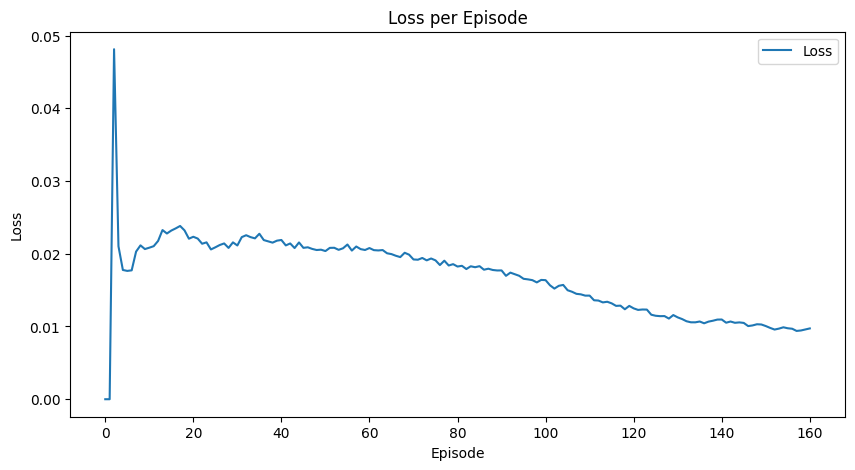

([22.084586412383494,
  16.24144231187782,
  25.35464034536894,
  13.741533189457044,
  23.555341781965854,
  11.90038828289606,
  31.603524379212878,
  30.794660520890574,
  26.26708945677563,
  25.62774180398634,
  23.105757372156987,
  24.81656377950327,
  38.04336671826665,
  20.592712719432146,
  25.733513325575878,
  23.638679379451215,
  36.44517458748823,
  21.285416948980075,
  18.276490187000892,
  21.42339900034495,
  22.663908443106852,
  23.747525110947876,
  22.320398377851554,
  20.68323110232633,
  18.30943945093658,
  34.05124545026482,
  21.791510583983687,
  21.654719203509035,
  21.97029110818286,
  34.86479826721007,
  23.905298661993736,
  35.49335044844978,
  24.75342429446452,
  28.332365098691415,
  24.098970768477688,
  19.134759571389026,
  21.386184267633304,
  24.02843447075624,
  25.604976976471544,
  21.7312904608295,
  19.752800686459143,
  27.799783528657724,
  17.427813818650222,
  13.164926263084633,
  36.321608032610925,
  16.40936083517034,
  23.807

In [11]:
# Train the DQN agent
rewards, losses = train_dqn_agent(env, agent, n_episodes=500, max_steps_per_episode=100, stop_loss_threshold=0.01)

In [21]:
def test_dqn_agent(env, agent, n_episodes=5, max_steps_per_episode=100):
    """
    Test the DQN agent in the environment for a given number of episodes with visualization.

    Args:
        env: The environment to test in.
        agent: The DQN agent.
        n_episodes: Number of episodes to run.
        max_steps_per_episode: Maximum number of steps per episode.

    Returns:
        total_rewards: List of total rewards obtained in each episode.
    """
    total_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Clear the previous plot
            clear_output(wait=True)

            # Plot the environment
            plt.figure(figsize=(8, 8))
            plt.xlim(0, env.area_size)
            plt.ylim(0, env.area_size)
            plt.scatter(env.users[:, 0], env.users[:, 1], color='blue', label='Users')
            plt.scatter(env.uavs[:, 0], env.uavs[:, 1], color='red', label='UAVs')

            # Calculate and plot distances/rewards
            total_coverage = np.zeros(env.users.shape[0])
            for i, uav in enumerate(env.uavs):
                distances = np.linalg.norm(env.users - uav, axis=1)
                coverage = np.exp(-distances)  # Exponential decay with distance
                total_coverage += coverage

                for j, user in enumerate(env.users):
                    plt.plot([uav[0], user[0]], [uav[1], user[1]], 'k-', lw=0.5)
                    plt.text((uav[0] + user[0]) / 2, (uav[1] + user[1]) / 2, f'{coverage[j]:.2f}', fontsize=8, color='green')

            # Plot coverage as a color intensity for each user
            plt.scatter(env.users[:, 0], env.users[:, 1], c=total_coverage, cmap='coolwarm', s=200, alpha=0.6, edgecolor='black')
            plt.colorbar(label='Coverage Intensity')

            plt.title(f'Episode {episode + 1}, Step {step + 1}')
            plt.legend()
            plt.show()

            state = next_state

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}/{n_episodes} | Total Reward: {total_reward:.2f}")

    avg_reward = np.mean(total_rewards)
    print(f"\nAverage Reward over {n_episodes} Test Episodes: {avg_reward:.2f}")

    return total_rewards

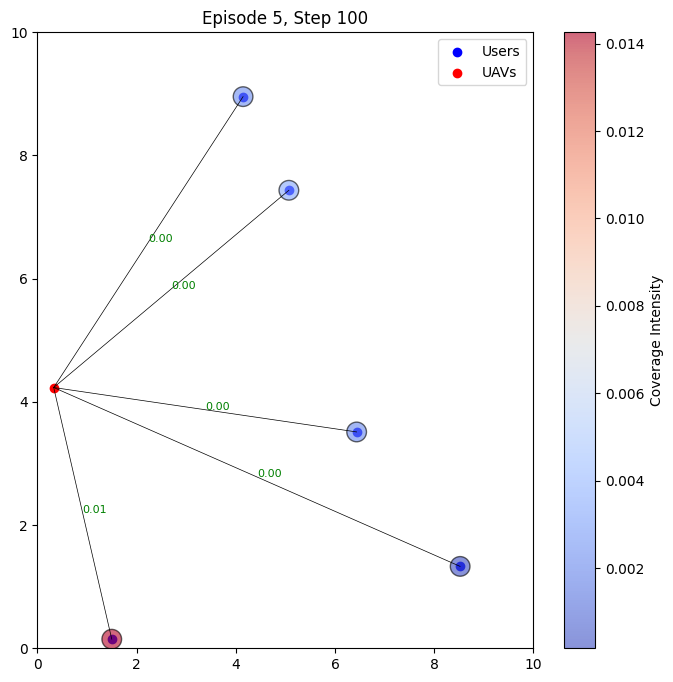

Test Episode 5/5 | Total Reward: 30.35

Average Reward over 5 Test Episodes: 29.02


In [22]:
test_rewards = test_dqn_agent(env, agent, n_episodes=5, max_steps_per_episode=100)